# RapidWright Tutorial - SAT Router
In this Jupyter notebook tutorial, we illustrate: 
 1. Introduce SAT-based solving engine for graph problems.
 2. The RapidWright SAT router interface and when to use it.
 3. Route an example that fails in Vivado but succeeds with the SAT Router.
 4. Show how to partially route a design with the SAT Router, and finish up with Vivado.
 
## Background
Routing, specifically congestion and timing closure, can be difficult challenges in FPGA implementation.  Silicon is expensive and we want to use it as efficiently as possible---driving us to push the limits of FPGA fabric capabilities.  In doing so, often we experience challenges routing a design to completion. 

In this tutorial, we introduce a SAT engine (based on [MiniSAT](http://minisat.se/)) that has been instrumented for graph-type problem/solutions and a RapidWright interface leveraging its capabilities.  We have built a RapidWright interface to the SAT engine solver such that routing problems can be described and routing solutions can be imported back into the RapidWright designs.   Note that the SAT solver is not a timing-driven router, but can solve exceptionally difficult congestion problems using an equal weight on routing wire lengths.  

## Get Started!
> **NOTE:** Sometimes running the external SAT engine can take several minutes and can cause the Jupyter kernel to timeout. We recommend users to copy and paste the commands below in a RapidWright terminal or script to ensure proper execution.

### Difficult Congestion Example:
Start by running the code below.  Note that we begin with a design that has already been unsuccessfully routed by Vivado.  Feel free to examine the design in Vivado beforehand as there are 7 overlaps in the routing that make it invalid.

In [ ]:
from com.xilinx.rapidwright.router import SATRouter
from com.xilinx.rapidwright.design import Design
from com.xilinx.rapidwright.device import Device
from com.xilinx.rapidwright.design.blocks import PBlock

# Load our design that failed to route in Vivado
design = Design.readCheckpoint("reduce_or_routed_7overlaps.dcp")

# We will unroute all the nets (except clk, GND, VCC)
for net in design.getNets():
    if net.isClockNet() or net.isStaticNet():
        continue
    net.unroute()

# Load the same pblock used in the Vivado design for area constraint
# Note: the SAT Router will treat the pblock as if the CONTAIN_ROUTING
#       flag was set in Vivado
pblock = PBlock(design.getDevice(),"SLICE_X108Y660:SLICE_X111Y664")
satRouter = SATRouter(design,pblock)

# Here is where we actually invoke the external SAT router
# a few log files will be generated and this processs can take
# several minutes.  This command will also process the output
# result from the SAT router and import it back into the RapidWright
# design.
satRouter.route()

design.writeCheckpoint("reduce_or_sat_routed.dcp")

Once complete, the user can open the resulting DCP ("reduce_or_sat_routed.dcp") in Vivado to examine the results.  One key Tcl command to run when checking the validity of a route os `report_route_status` which can report on intimate details of the routing state.  Here is an example of what the results might look like:

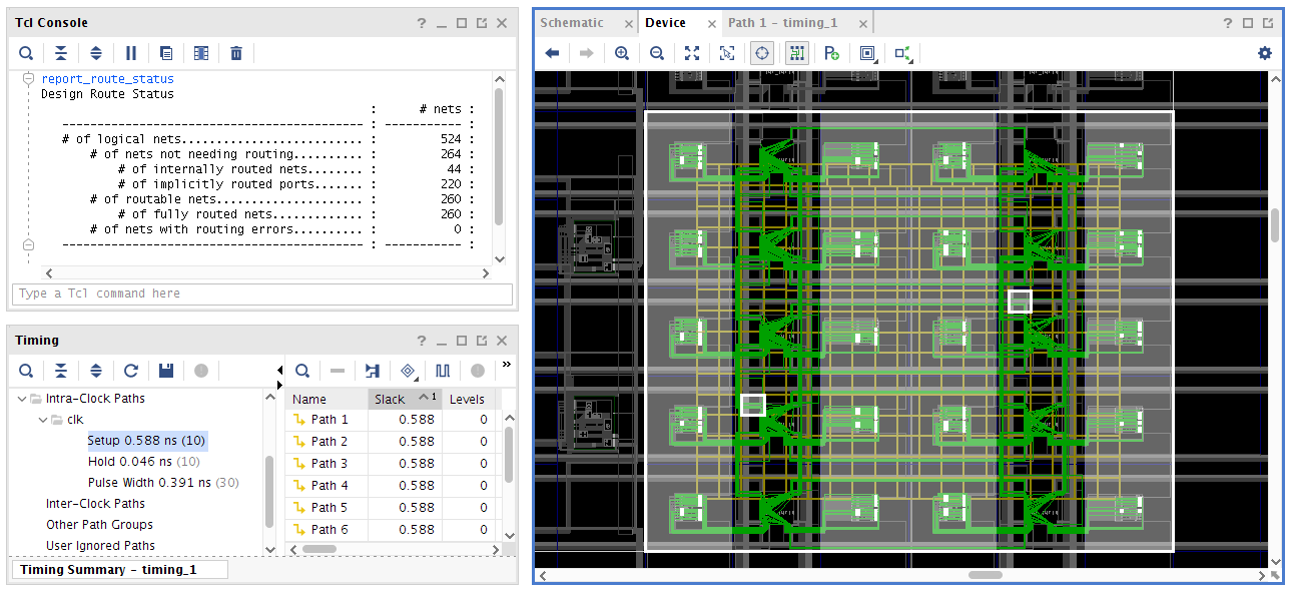

### Partial Routing Example:
Another use case for the SAT router is to partially route a portion of a design.  This can happen if there is particularly difficult congestion in one part of the fabric.  Again, the same approach is used by designating the area to be routed with a pblock, but this time we start with a fully placed design, run the SAT router to route our pblocked-area and then open it back in Vivado to perform the final route of the design.

In [ ]:
from com.xilinx.rapidwright.router import SATRouter
from com.xilinx.rapidwright.design import Design
from com.xilinx.rapidwright.device import Device
from com.xilinx.rapidwright.design.blocks import PBlock

# Load the same design used in the ILA Probe Re-router example
# we will unroute the design, so that we can route a portion 
# of it with the SAT router
design = Design.readCheckpoint("microblaze_with_ila_routed.dcp")
design.unrouteDesign()


# We will choose the area to be routed -- The SAT Router
# automatically determines which nets are physically within
# the pblock and will include them in the routing problem
# to the SAT Router
pblock = PBlock(design.getDevice(),"SLICE_X68Y134:SLICE_X72Y149")
satRouter = SATRouter(design,pblock)

# Here is where we actually invoke the external SAT router
# a few log files will be generated and this processs can take
# several minutes.  This command will also process the output
# result from the SAT router and import it back into the RapidWright
# design.
satRouter.route()

design.writeCheckpoint("microblaze_partially_sat_routed.dcp")

Opening the design in Vivado will show a rectangular block of routed signals in the design as shown below:

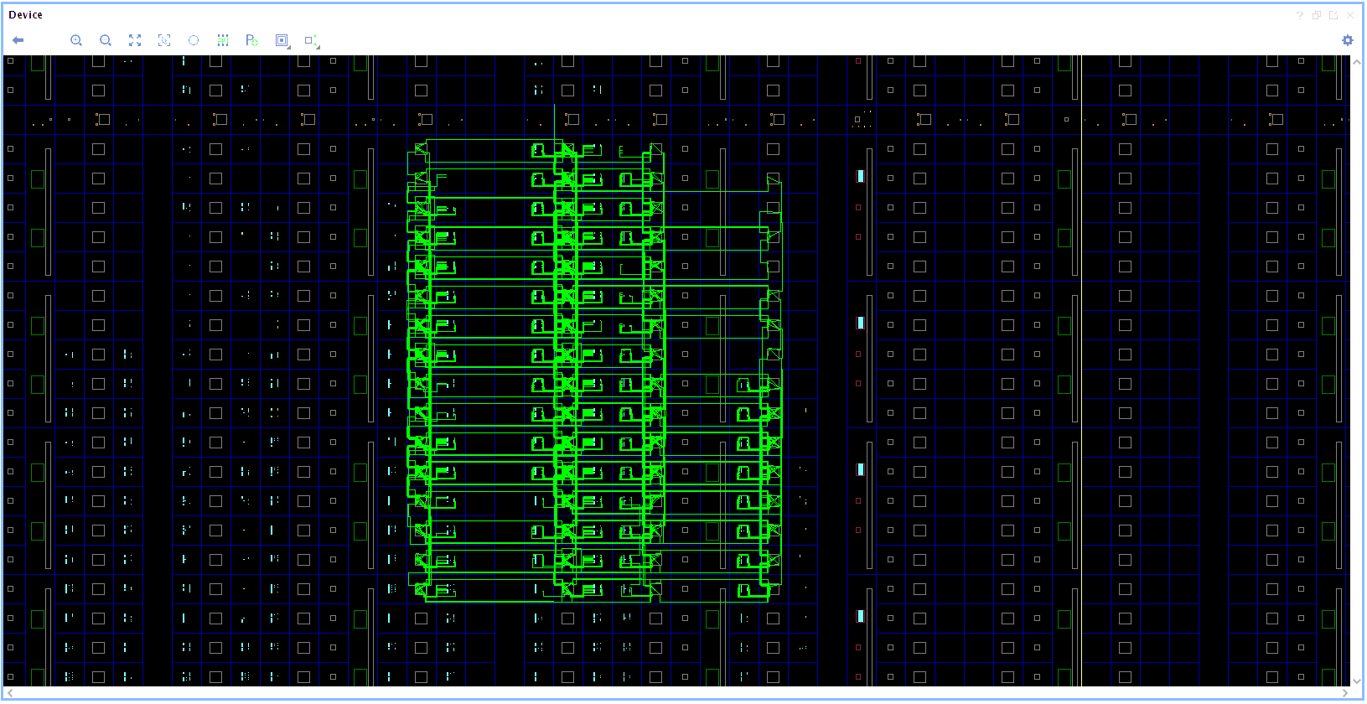

Currently, the SAT Router is still under development and may not perform correctly in all circumstances.  We welcome feed back to help improve its performance.